In [2]:
# Importing modules
import warnings

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS

from statsmodels.api import add_constant
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings(action='ignore')

In [3]:
## importing dataset
data = pd.read_csv('prediction-exercise-2022-23.csv', parse_dates=['yyyymm']).drop(columns = ['Unnamed: 0', 'csp'])
## not reading CSP because on previous inspection the column is only available between 1937 and 2002 
data.head()

,yyyymm,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,return
0,192102,0.5017,0.7150,NaN,0.0530,0.0608,0.0842,0.0528,NaN,0.004725,-0.031579,NaN,NaN,0.000731,-0.007057
1,192103,0.4975,0.6725,0.636220,0.0538,0.0608,0.0855,0.0527,NaN,0.004417,-0.005435,NaN,NaN,0.002308,-0.025826
2,192104,0.4933,0.6300,0.613466,0.0520,0.0606,0.0853,0.0524,NaN,0.004483,-0.010929,NaN,NaN,0.001656,0.004351
3,192105,0.4892,0.5875,0.656318,0.0516,0.0611,0.0852,0.0525,NaN,0.004333,-0.022099,NaN,NaN,0.001319,0.029938
4,192106,0.4850,0.5450,0.704164,0.0499,0.0618,0.0856,0.0527,NaN,0.004300,-0.005650,NaN,NaN,0.003864,-0.083443


In [4]:
## by default pandas assumes that observations are recorded in the beginning of each month since date only contains month and years.
## since returns for a month are calculated at the end of each month, manually adding the last day of each month in the date.
def change_date_end(date):
    Date = pd.to_datetime(date, format="%Y%m") + pd.tseries.offsets.MonthEnd(0)
    return Date

In [5]:
data['Date'] = data.yyyymm.apply(change_date_end)
data.drop(columns = ['yyyymm'], inplace = True)
data['next_return'] = data['return'].shift(-1)
data['Term_spread'] = data['lty'] - data['tbl'] 
data.set_index('Date', inplace=True)
data.head()

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,return,next_return,Term_spread
Date,,,,,,,,,,,,,,,,
1921-02-28,0.5017,0.7150,NaN,0.0530,0.0608,0.0842,0.0528,NaN,0.004725,-0.031579,NaN,NaN,0.000731,-0.007057,-0.025826,-0.0002
1921-03-31,0.4975,0.6725,0.636220,0.0538,0.0608,0.0855,0.0527,NaN,0.004417,-0.005435,NaN,NaN,0.002308,-0.025826,0.004351,-0.0011
1921-04-30,0.4933,0.6300,0.613466,0.0520,0.0606,0.0853,0.0524,NaN,0.004483,-0.010929,NaN,NaN,0.001656,0.004351,0.029938,0.0004
1921-05-31,0.4892,0.5875,0.656318,0.0516,0.0611,0.0852,0.0525,NaN,0.004333,-0.022099,NaN,NaN,0.001319,0.029938,-0.083443,0.0009
1921-06-30,0.4850,0.5450,0.704164,0.0499,0.0618,0.0856,0.0527,NaN,0.004300,-0.005650,NaN,NaN,0.003864,-0.083443,-0.003058,0.0028


In [6]:
# creating a 'change' feature and stationarising all the data by 1st differencing 
for column in data.columns: 
    # don't touch returns or next returns
    if((column == 'next_return')):
        continue
    column_shifted = data[column].shift(1) # 1 period before t
    change = column_shifted - data[column] ## calculating how much the parameter has changed in the period.
    data[column + '_change'] = change
data.head() 

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,...,BAA_change,lty_change,ntis_change,Rfree_change,infl_change,ltr_change,corpr_change,svar_change,return_change,Term_spread_change
Date,,,,,,,,,,,,,,,,,,,,,
1921-02-28,0.5017,0.7150,NaN,0.0530,0.0608,0.0842,0.0528,NaN,0.004725,-0.031579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921-03-31,0.4975,0.6725,0.636220,0.0538,0.0608,0.0855,0.0527,NaN,0.004417,-0.005435,...,-0.0013,0.0001,NaN,0.000308,-0.026144,NaN,NaN,-0.001577,0.018769,0.0009
1921-04-30,0.4933,0.6300,0.613466,0.0520,0.0606,0.0853,0.0524,NaN,0.004483,-0.010929,...,0.0002,0.0003,NaN,-0.000066,0.005494,NaN,NaN,0.000651,-0.030177,-0.0015
1921-05-31,0.4892,0.5875,0.656318,0.0516,0.0611,0.0852,0.0525,NaN,0.004333,-0.022099,...,0.0001,-0.0001,NaN,0.000150,0.011170,NaN,NaN,0.000337,-0.025587,-0.0005
1921-06-30,0.4850,0.5450,0.704164,0.0499,0.0618,0.0856,0.0527,NaN,0.004300,-0.005650,...,-0.0004,-0.0002,NaN,0.000033,-0.016450,NaN,NaN,-0.002544,0.113381,-0.0019


In [7]:
# filling all except the first row nan with previos values and droping the first 71 rows of data.
data = data.fillna(method='ffill').dropna() 

In [8]:
# segregating stationary series only for future analysis
stationary_1st_dif = []
for column in data.columns: # entire dataset
    pval = adfuller(data.loc[:, column])[1]
    if(pval < 0.05):
        stationary_1st_dif.append(column)
data_model = data.loc[:, stationary_1st_dif] ## keeping only stationary timeseries

In [9]:
## creating a function to plot how the investment of 1$ grows overtime with strategy vs long_only and calculation the startegy sharpe
## calculates other metrics to evaluate strategy performance
def cal_strategy_metrics(df_pred_obs): #assuming  +ve prediction for going long, negative for short
    df_pred_obs['move'] = df_pred_obs.pred.apply(lambda x: 1 if x > 0 else -1)
    df_pred_obs['my_returns'] = df_pred_obs.obs * df_pred_obs.move
    df_pred_obs['rolling_move'] = df_pred_obs['mean'].apply(lambda x: 1 if x > 0 else -1)
    df_pred_obs['rolling_returns'] = df_pred_obs.obs * df_pred_obs.rolling_move
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot(np.cumprod(1 + df_pred_obs['my_returns']), label = 'My portfolio')
    plt.plot(np.cumprod(1 + df_pred_obs['obs']), label = 'LONG ONLY RETURNS')
    plt.title('Dollar amount invested, long only vs using strategy')
    plt.legend()
    plt.show()
    win_ratio = len(df_pred_obs[df_pred_obs.my_returns > 0])/ len(df_pred_obs)
    print('Win ratio:', win_ratio)
    short_trades = df_pred_obs[df_pred_obs.move == -1]
    long_trades = df_pred_obs[df_pred_obs.move == 1]
    print('total long positions', len(long_trades))
    print('total short positions', len(short_trades))
    net_long_returns = np.prod(1 + long_trades.my_returns) - 1
    print('net_long_returns', net_long_returns)
    net_short_returns = np.prod(1 + short_trades.my_returns) - 1
    print('net_short_returns', net_short_returns)
    ## calculating Sortino ratio
    neg_returns = df_pred_obs[df_pred_obs.my_returns < 0]
    std_neg = neg_returns.my_returns.std()
    print('model sortino: ',((df_pred_obs['my_returns'] - df_pred_obs['Rfree']).mean() *(12**0.5))/ std_neg ) ## anualizing the ratio
    
    print('market sharpe: ',((df_pred_obs.obs- df_pred_obs['Rfree']).mean()/df_pred_obs.obs.std()) * (12**0.5) )
    portfolio_sharpe = (df_pred_obs['my_returns'] - df_pred_obs['Rfree']).mean()/df_pred_obs['my_returns'].std() * (12**0.5) ## anualizing the monthly sharpe


    ## calculating drawdown
    comp_ret = (df_pred_obs.my_returns + 1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak) -1
    Max_drawdown = dd.min()
    print('Max drawdown', Max_drawdown )
    ## Calculating calmer ratio
    print("calmer's ratio", df_pred_obs.my_returns.mean()*(12**0.5)/np.abs(Max_drawdown))
    return portfolio_sharpe

In [10]:
def calculate_rolling_corr(data_cal, window_len = 10):
    # Calculates the rolling correlation for all factors (Stationary ones)  
    rolling_corr_df = pd.DataFrame(columns = data_cal.columns)
    # window_len = 10
    for period in range(len(data_cal.index) - window_len ):# constructing a rolling window 
        current_df = data_cal.iloc[period : period + window_len, :] # all columns in the rolling period
        columns_ = np.array(current_df.corr()['next_return'].index)
        values = np.matrix(current_df.corr()['next_return'].values)
        ## 
        current_corr_df = pd.DataFrame(values, columns = columns_, index = [data_cal.index[period + window_len]])
        rolling_corr_df = pd.concat([rolling_corr_df, current_corr_df])
    rolling_corr_df.head()
    return rolling_corr_df 

In [11]:

def strategy(train_test_data, threshold_corr = 0.4, window_len = 6, train_window_len = 12): # train_test_data must not have any outliers!
    # train test data : last observation is the one I want the prediction for, use rest to estimate parameters and training.
    train_df = train_test_data.iloc[-train_window_len:-1, ]# all but last row and all columns
    test_df = train_test_data.iloc[-1:,: ] # Last observation for the dataset
    # Find predictors for the training data
    rolling_corr_df = calculate_rolling_corr(train_df, window_len)
    # estimating rolling rolling correlation forthe TRAINING dataset  
    last_corr = pd.DataFrame(rolling_corr_df.iloc[-1, :].drop('next_return'))
    last_corr['absolute'] = np.abs(last_corr.values)
    
    features = last_corr[last_corr.absolute > threshold_corr].index
    # Using the features with correlation > threshold correlation in the last 6 months
    X_train = train_df.loc[:,features]
    X_train = add_constant(X_train)
    y_train = train_df.next_return
    # tell me which data to use for model training
    # train the model
    model = OLS(y_train,X_train).fit()
    # tell me which data to predict on
    # X_test = test_df
    # generate prediction 
    X_test = test_df.loc[:, features]
    X_test = add_constant(X_test, has_constant='add')
    y_observed = test_df.next_return
    y_predictions = model.predict(X_test)
    # print(len(y_predictions))
    return y_predictions.values[0]

In [12]:
# set up code that itteratively calls the strategy function with updated data.
# the testing data keeps expanding with every itteration in the strategy
def strategy_helper(train_df, test_df, threshold_corr, window_len, train_window_len):
    y_predictions = []
    for index in test_df.index:
        temp_df = pd.concat([train_df, test_df.loc[:index,]]) ## unitil the testing index
        y_predictions.append(strategy(temp_df, threshold_corr = threshold_corr, window_len=window_len, train_window_len = train_window_len))
    return y_predictions

In [13]:
train_df = data_model['1921-01':'2019-01'][(data_model['next_return'] >= -0.15) & (data_model['next_return'] <= 0.15)]

test_df = data_model['2019-02':]#[(data_model['next_return'] >= -0.15) & (data_model['next_return'] <= 0.15)]
print(train_df.shape)

(1086, 23)


In [14]:
y_predictions = strategy_helper(train_df=train_df, test_df=test_df, threshold_corr = 0.6, window_len = 6, train_window_len = 160)
## uses 160 months of data for each itteration, the window lenghth =6, implies rolling correlation calculation each month for the last 6 months 

35
35
<class 'numpy.ndarray'>


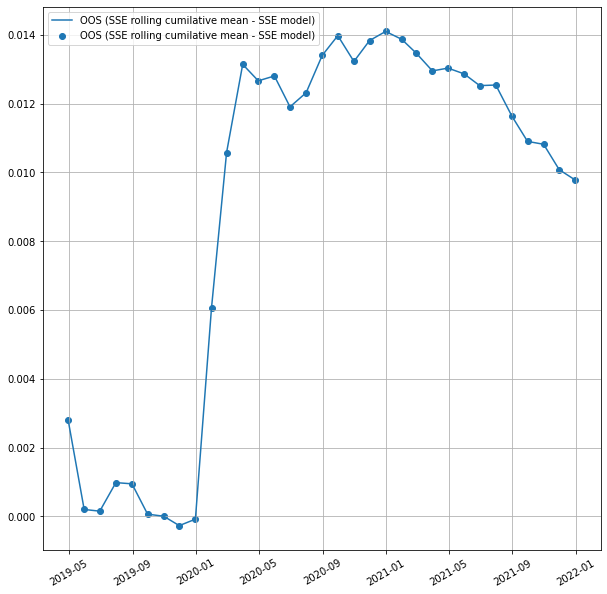

MODEL OOS MSE:  0.0023590594614194896
MEAN OOS MSE:  0.002763259488424405


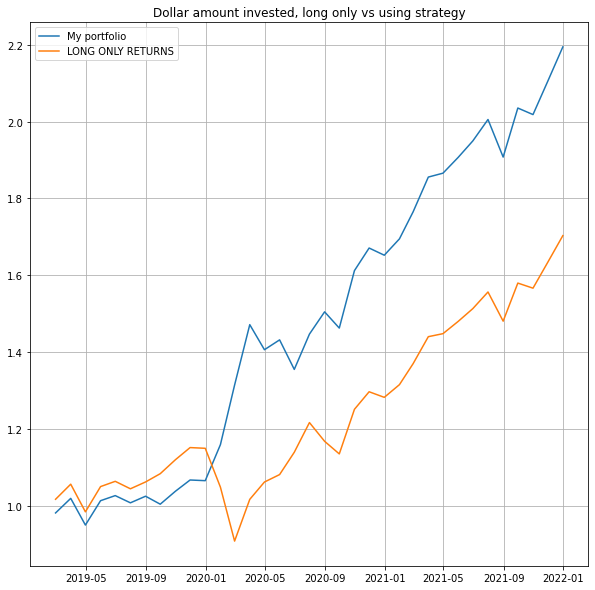

Win ratio: 0.6857142857142857
total long positions 28
total short positions 7
net_long_returns 0.9654299774512751
net_short_returns 0.11641651091161731
model sortino:  3.7415110084534304
market sharpe:  1.0972923359453157
Max drawdown -0.07906751737077122
calmer's ratio 1.040759667912459
Model_sharpe:  1.6962466640897536


In [22]:
y_observed = test_df.next_return

print(len(y_observed))
print(len(y_predictions))



rolling_mean = test_df.rolling(len(data), min_periods=2)['return'].mean().shift(1).dropna()

OOS_SSE_mean = np.power(rolling_mean['2019-02':] - y_observed, 2)
OOS_SSE_model = np.power(y_predictions - y_observed, 2)

print(type(np.cumsum(OOS_SSE_mean -OOS_SSE_model).values))

plt.figure(figsize=(10,10))
plt.plot(np.array(y_observed.index), np.cumsum(OOS_SSE_mean -OOS_SSE_model).values, label = 'OOS (SSE rolling cumilative mean - SSE model)')
plt.scatter(np.array((y_observed.index)), np.cumsum(OOS_SSE_mean -OOS_SSE_model), label = 'OOS (SSE rolling cumilative mean - SSE model)')

plt.xticks(rotation = 30)
plt.grid()
plt.legend()
plt.show()

print("MODEL OOS MSE: ", mean_squared_error(y_predictions,y_observed))
print("MEAN OOS MSE: ", mean_squared_error(rolling_mean['2019-02':],y_observed[2:]))
print('Model_sharpe: ', cal_strategy_metrics(df_pred_obs= pd.DataFrame({'pred': y_predictions,'obs':y_observed,'mean': rolling_mean['2019-02':], 'Rfree':data.loc[test_df.index, 'Rfree']})))

## static model instead of a dynamic model: not recommended

In [29]:
## If the previous 'strategy' is unacceptable, here is a single (static) model that trains on the training data and predicts accross the testing data. 
# single model, instead of remodelling based on factor exposure every month

train_df = data_model['1921-01':'2019-01'][(data_model['next_return'] >= -0.15) & (data_model['next_return'] <= 0.15)]
test_df = data_model['2019-02':][(data_model['next_return'] >= -0.15) & (data_model['next_return'] <= 0.15)]


features = [ 'b/m_change', 'corpr_change', 'ntis', 'Term_spread_change']


X_train = train_df.loc[:,features]
X_train = add_constant(X_train)
y_train = train_df.next_return

model = OLS(y_train,X_train).fit()
print(model.summary())

X_test = test_df.loc[:, features]
X_test = add_constant(X_test, has_constant='add')
y_observed = test_df.next_return
y_predictions = model.predict(X_test)

                            OLS Regression Results                            
Dep. Variable:            next_return   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.895
Date:                Mon, 16 Oct 2023   Prob (F-statistic):             0.0212
Time:                        04:14:52   Log-Likelihood:                 1859.4
No. Observations:                1086   AIC:                            -3709.
Df Residuals:                    1081   BIC:                            -3684.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0071      0

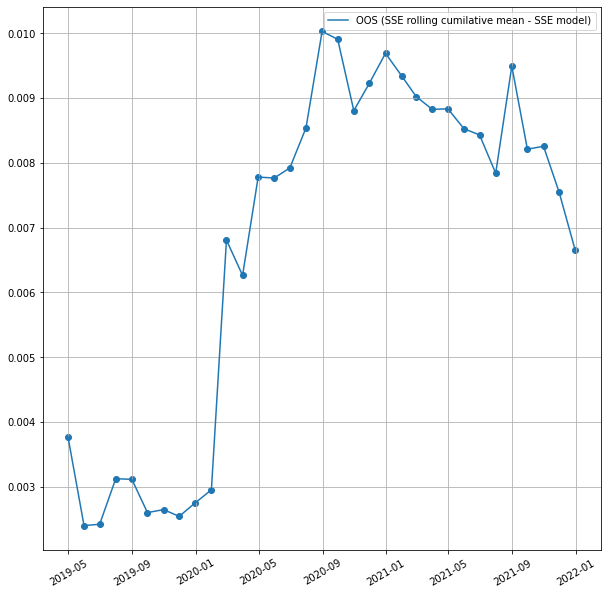

MODEL OOS MsE:  0.0024378629962494573
MEAN OOS MsE:  0.002763259488424405
Market average/Expected return :  0.016576257829475742


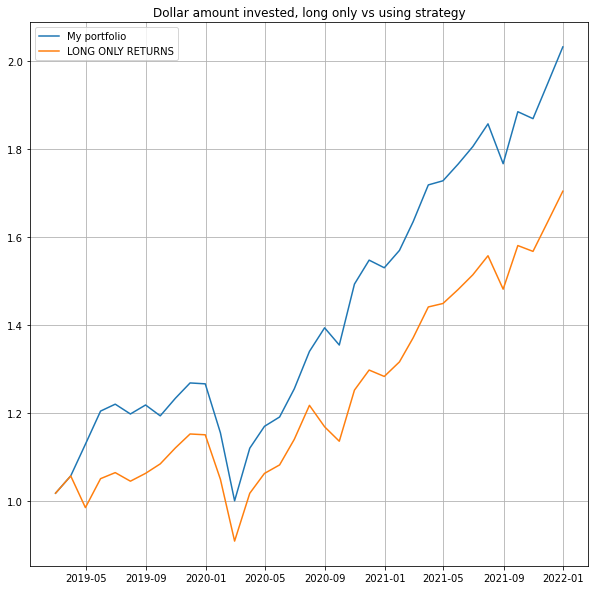

Win ratio: 0.7428571428571429
total long positions 32
total short positions 3
net_long_returns 0.8662303304519061
net_short_returns 0.08831538592725297
model sortino:  1.6489626993175963
market sharpe:  1.0972923359453157
Max drawdown -0.2110708956107885
calmer's ratio 0.3544226238920641
Model_sharpe:  1.5037440525565264


In [30]:
rolling_mean = test_df.rolling(len(data), min_periods=2)['return'].mean().shift(1).dropna()

OOS_SSE_mean = np.power(rolling_mean['2019-02':] - y_observed, 2)
OOS_SSE_model = np.power(y_predictions - y_observed, 2)

plt.figure(figsize=(10,10))
plt.plot(np.array(y_predictions.index), np.cumsum(OOS_SSE_mean -OOS_SSE_model).values, label = 'OOS (SSE rolling cumilative mean - SSE model)')
plt.scatter(np.array(y_predictions.index), np.cumsum(OOS_SSE_mean -OOS_SSE_model).values)#, label = 'OOS (SSE rolling cumilative mean - SSE model)')
plt.xticks(rotation = 30)
plt.grid()
plt.legend()
plt.show()


print("MODEL OOS MsE: ", mean_squared_error(y_predictions,y_observed))

print("MEAN OOS MsE: ", mean_squared_error(rolling_mean['2019-02':],y_observed[2:]))

print('Market average/Expected return : ', y_observed.mean())
print('Model_sharpe: ', cal_strategy_metrics(df_pred_obs= pd.DataFrame({'pred': y_predictions,'obs':y_observed,'mean': rolling_mean['2019-02':], 'Rfree':data.loc[X_test.index, 'Rfree']})))


## end of notebook